In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import  numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [2]:
df = pd.read_pickle('../../output/239-3600-we-wa-se.pkl', compression='gzip')

# Filter out the columns

In [93]:
df_r = df[['prcp', 'clean_water_usage_day', 'outflow_level','sea_level_last_30min', 'sea_level_next_30min']]

# Add Features
- Precipitation [-1H]
- Month
- Hour
- Sea tide
- \(Holiday\)

In [94]:
# Add prcp from previous row for each row:
df_r['prcp_prev'] = df_r.prcp.shift(1)

In [95]:
# Set month number from datetime index:
df_r['month'] = df_r.index.month

In [96]:
# Add hour from datetime index:
df_r['hour'] = df_r.index.hour

In [97]:
df_r = df_r.reset_index()
df_r = df_r.rename(columns={'index': 'datetime'})

In [98]:
df_r = df_r.dropna()
column_to_move = df_r.pop("outflow_level")
df_r.insert(0, "outflow_level", column_to_move)

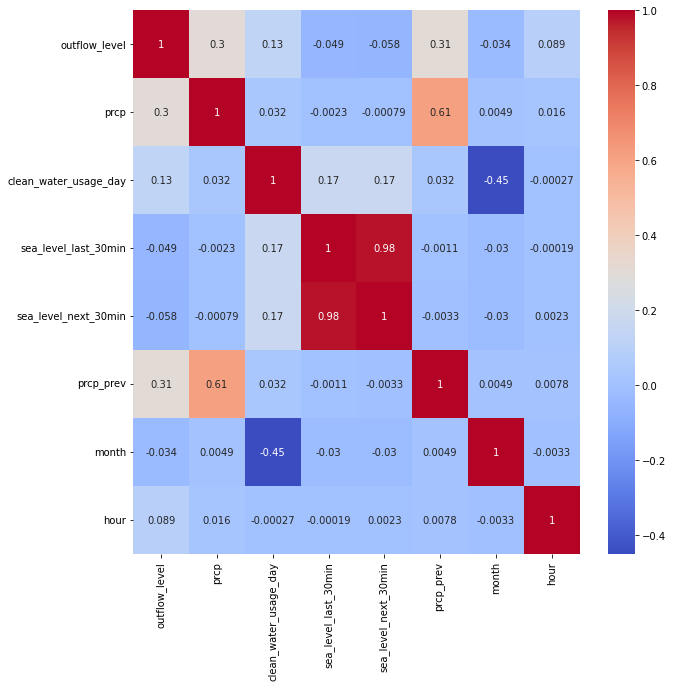

In [99]:
c = df_r.corr()
fig = sns.heatmap(c, cmap='coolwarm', annot=True)

# Increase figure size
fig.figure.set_size_inches(10, 10)

# Learning

In [14]:
train, test = train_test_split(df_r, test_size=0.2, random_state=1)
X, y = df_r.drop(['outflow_level', 'datetime'], axis=1).to_numpy(), df_r.outflow_level.to_numpy()
train_X = train.drop(['outflow_level','datetime'], axis=1).to_numpy()
train_y = train.outflow_level.to_numpy()
test_X = test.drop(['outflow_level', 'datetime'], axis=1).to_numpy()
test_y = test.outflow_level.to_numpy()

# Grid Search CV for LightGBM

In [10]:
# parameters = {
#     'boosting_type': ['gbdt', 'dart'],
#     'max_depth': [1, 5, 10, 20, 50, 100],
#     'num_leaves': [8,10, 20,30],
#     'learning_rate': [0.01,0.05, 0.1, 0.5, 1.0],
#     'n_estimators': [50,100,200,300],
# }
# scoring = 'neg_mean_squared_error'
# gs = GridSearchCV(lgb.sklearn.LGBMRegressor(objective='regression'), parameters, cv=5, scoring=scoring, n_jobs=8)
# gs.fit(train_X, train_y)
# gs.best_params_, gs.best_score_

# Grid Search CV for XGBoost

In [11]:
# parameters = {
#     'max_depth': [1,2,3],
#     'n_estimators': [35,50,60,100],
#     'eta': [0.05, 0.1, 0.2, 0.5],
#     'subsample': [1.0],
#     'colsample_bytree': [1.0],
# }
# gs = GridSearchCV(XGBRegressor(objective='reg:squarederror'), parameters, cv=5, scoring=scoring, n_jobs=8)
# gs.fit(train_X, train_y)
# gs.best_params_, gs.best_score_

# Grid Search CV for Decision Tree

In [12]:
# parameters = {
#     'max_depth': [1,2,3],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [1,2,3],
# }
# gs = GridSearchCV(DecisionTreeRegressor(), parameters, cv=5, scoring=scoring, n_jobs=8)
# gs.fit(train_X, train_y)
# gs.best_params_, gs.best_score_

# Grid Search CV for Random Forest

In [13]:
# parameters = {
#     'max_depth': [1,2,3],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [1,2,3],
# }
# gs = GridSearchCV(RandomForestRegressor(), parameters, cv=5, scoring=scoring, n_jobs=8)
# gs.fit(train_X, train_y)
# gs.best_params_, gs.best_score_

# Grid Search CV for SVR

In [14]:
# parameters = {
#     'kernel': ['rbf', 'linear', 'poly'],
#     'C': [0.1, 1, 10, 100],
# }
# gs = GridSearchCV(SVR(), parameters, cv=5, scoring=scoring, n_jobs=8)
# gs.fit(train_X, train_y)
# gs.best_params_, gs.best_score_

# Validation

In [15]:
regr_list = [
    DummyRegressor(strategy='mean'),
    RandomForestRegressor(max_depth=3, min_samples_split=3, min_samples_leaf=1),
    DecisionTreeRegressor(max_depth=5),
    XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=60, eta=0.2, subsample=1, colsample_bytree=1),
    lgb.sklearn.LGBMRegressor(objective='regression', boosting_type='dart', max_depth=20, num_leaves=20, learning_rate=0.1, n_estimators=200),
]

def get_score(regr):
    score_cv = cross_val_score(regr, train_X, train_y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    regr.fit(train_X, train_y)
    score_test = mean_squared_error(test_y, y_pred=regr.predict(test_X))
    print("Mean-CV score: {:.2f}\t Test score: {:.2f}".format(np.mean(-score_cv), score_test))

for regr in regr_list:
    get_score(regr)

Mean-CV score: 200.07	 Test score: 223.39
Mean-CV score: 159.81	 Test score: 172.40
Mean-CV score: 179.01	 Test score: 200.64


/Users/nielstiben/miniforge3/envs/MLOPS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nielstiben/miniforge3/envs/MLOPS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nielstiben/miniforge3/envs/MLOPS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nielstiben/miniforge3/envs/MLOPS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Mean-CV score: 156.38	 Test score: 156.49
Mean-CV score: 149.12	 Test score: 144.71


In [16]:
regr = lgb.sklearn.LGBMRegressor(objective='regression', boosting_type='dart', max_depth=20, num_leaves=20, learning_rate=0.1, n_estimators=200)
# regr.fit(train_X, train_y)

In [ ]:
regr.fit(train_X, train_y)

# Output Results

In [ ]:
y_pred = regr.predict(test_X)
df_pred = pd.DataFrame(test.datetime)
df_pred['y'] = y_pred
df_pred['Type'] = 'Predicted'

df_true = pd.DataFrame(test.datetime)
df_true['y'] = test_y
df_true['Type'] = 'True'

# Merge the two dataframes
df_pred_true = pd.concat([df_pred, df_true])

In [ ]:
# Plot the true data against the predicted data on scatter plot
fig = px.scatter(
    df_pred_true,
    x="datetime",
    y="y",
    color="Type",
    title="Predicted vs True",
    color_discrete_sequence=px.colors.qualitative.Light24
)
fig.show()

In [ ]:
y_pred = regr.predict(test_X)
df = pd.DataFrame(test.datetime)
df['pred'] = y_pred
df['true'] = test_y
df['difference'] = df.true - df.pred

In [ ]:
fig = go.Figure(
    data=go.Scatter(
        x=df.datetime,
        y=df.true,
        mode='markers',
        error_y=dict(
            type='data',
            symmetric=False,
            array=-df.difference.to_numpy(),
            color='red'
        ),
        marker=dict(color='rgba(0, 181, 30, 1)', size=8)
    ),
)
fig.update_layout(title_text="Error range - green dot is ground truth",)
fig.show()